# GRUPO 3:

LAURA HERRERA

YUDDY LORENA GIRALDO

CARLOS VASQUEZ

In [ ]:
!pip install factor-analyzer

In [ ]:
!pip install kneed

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# para PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
# GMM
from sklearn import cluster
from sklearn.metrics import silhouette_score # indicador para consistencia de cluster
from kneed import KneeLocator # para identificar analiticamente el cambio de la pendiente
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

Diccionario de datos

CUST_ID: Identificación del titular de la tarjeta de crédito

BALANCE: Saldo disponible para compras

BALANCE_FREQUENCY: Frecuencia de actualización del saldo (donde 1 = actualización frecuente y 0 = no se actualiza con frecuencia).

PURCHASES: Importe de las compras realizadas por el cliente

ONEOFF_PURCHASES: Importe máximo de la compra realizada a una couta

INSTALLMENTS_PURCHASES: Importe de las compras realizadas a plazos

CASH_ADVANCE: Avances de Efectivo realizados por el usuario

PURCHASES_FREQUENCY: Frecuencia con la que se realizan las compras (1 = compras frecuentes, 0 = compras poco frecuentes)

ONEOFF_PURCHASES_FREQUENCY: frecuencia con la que se realizan las compras a una couta (1 = compras frecuentes, 0 = compras poco frecuentes)

PURCHASES_INSTALLMENTS_FREQUENCY: Frecuencia con la que se realizan compras a plazos (1 = se realizan con frecuencia, 0 = no se realizan con frecuencia)

CASH_ADVANCE_FREQUENCY: Frecuencia con la que se realizan avances de efectivo

CASH_ADVANCE_TRX: Número de transacciones realizadas por "avances de efectivo"

PURCHASES_TRX: Número de transacciones de compra realizadas

CREDIT_LIMIT: Límite de la tarjeta de crédito del usuario

PAYMENTS: Importe de los pagos realizados por el usuario

MINIMUM_PAYMENTS: Importe mínimo de los pagos realizados por el usuario

PRC_FULL_PAYMENT: Porcentaje del pago total abonado por el usuario

TENURE: Tenencia del servicio de tarjeta de crédito para el usuario

In [94]:
# para que los resultados no salgan en notacion cientifica
np.set_printoptions(precision=4, suppress=True)

In [95]:
# cargar base de datos
df = pd.read_csv('/content/drive/MyDrive/credit_card_clients.csv')

In [96]:
# funcion para hacer un resumen de la informacion de la base de datos
from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)

In [97]:
def check_df(dataframe, head=10):
    display(Markdown('**Dimensiones base general**'))
    display(dataframe.shape)

    display(Markdown('**Dimensiones sin duplicados**'))
    display(dataframe.drop_duplicates().shape )

    display(Markdown('**Tipos**'))
    display(dataframe.dtypes)

    display(Markdown('**Primeros Registros**'))
    display(dataframe.head(head))

    display(Markdown('**Nulos**'))
    display(dataframe.isnull().sum())

    display(Markdown('**Percentiles**'))
    display(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
check_df(df)

**Dimensiones base general**

(8950, 18)

**Dimensiones sin duplicados**

(8950, 18)

**Tipos**

CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object

**Primeros Registros**

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12


**Nulos**

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

**Percentiles**

,count,mean,std,min,0%,5%,50%,95%,99%,100%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,0.000000,8.814518,873.385231,5909.111808,9338.804814,19043.13856,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.000000,0.272727,1.000000,1.000000,1.000000,1.00000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,0.000000,0.000000,361.280000,3998.619500,8977.290000,49039.57000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,0.000000,38.000000,2671.094000,6689.898200,40761.25000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,0.000000,89.000000,1750.087500,3886.240500,22500.00000,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,0.000000,4647.169122,9588.163357,47137.21176,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.000000,0.000000,0.500000,1.000000,1.000000,1.00000,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.000000,0.083333,1.000000,1.000000,1.00000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.000000,0.166667,1.000000,1.000000,1.00000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.000000,0.583333,0.833333,1.50000,1.50000


In [118]:
# porcentaje de nulos
(313/8950)*100

3.4972067039106145

Se identifican datos nulos en la variable *MINIMUM_PAYMENTS*. Se decide eliminarlos ya que representa un porcentaje muy bajo del total de los datos y no se hace un tratamiento porque no tenemos suficiente conocimiento respecto a la base utilizada

# Reducción de dimensiones

In [99]:
# Eliminar variable CUST_ID
df2 = df.drop('CUST_ID', axis = 1)
# Eliminar datos nulos
df2 = df2.dropna()

Se decide eliminar la variable *CUST_ID* porque es una variable categorica y pasarla a dummies no es significativo para el modelo, ya que cada registro es único.

In [100]:
# Escalar los datos
feat_sc = StandardScaler().fit_transform(df2)

In [101]:
# Afinamiento de parametros
pca = PCA(n_components = 8)
# ajuste de datos
pca.fit(feat_sc)
# Lambdas, vectores propios, o pesos observados sobre las latentes
pca.components_

array([[ 0.092 ,  0.1098,  0.4122,  0.3468,  0.3371, -0.0306,  0.3237,
         0.2948,  0.2772, -0.0991, -0.057 ,  0.3911,  0.2101,  0.2637,
         0.0593,  0.1306,  0.0779],
       [ 0.406 ,  0.1277,  0.0495,  0.0699, -0.0115,  0.4372, -0.1866,
        -0.0147, -0.1736,  0.43  ,  0.4164, -0.0119,  0.2438,  0.2642,
         0.1704, -0.1957, -0.0046],
       [-0.1742, -0.4589,  0.2426,  0.3686, -0.1038, -0.0017, -0.3557,
         0.1047, -0.4499, -0.0876, -0.0871, -0.0798,  0.0952,  0.2879,
        -0.2487,  0.1842, -0.0657],
       [ 0.2594,  0.1593,  0.064 ,  0.1231, -0.075 , -0.2656, -0.2217,
         0.0555, -0.2653, -0.2666, -0.3326, -0.0241,  0.1227, -0.0975,
         0.3522, -0.4182,  0.4284],
       [ 0.0757, -0.4509, -0.0104, -0.197 ,  0.3375,  0.0994, -0.0885,
        -0.5216,  0.1754, -0.1599, -0.0897, -0.0525,  0.132 ,  0.1892,
         0.4168,  0.2011,  0.1178],
       [ 0.0358, -0.0147,  0.196 ,  0.173 ,  0.1454, -0.1325, -0.0857,
        -0.0968, -0.0475,  0.0315, -0.0

1. Cuáles son las variables observadas más importantes en las dos variables latentes más importantes.


Inicialmente, para la reducción de dimensiones consideramos el valor máximo de variables latentes posibles, en este caso 17. Sin embargo, identificamos que las dos primeras variables latentes explicaban aproximadamente el 45% y el resto menos del 10%. Por lo tanto, decidimos reducir el número de componentes a más o menos la mitad, es decir 8.

In [102]:
# valores propios = cantidad de varianza explicada
pca.explained_variance_
# porcentaje de varianza explicada. Con esta se hace la regla del codo
ve = pca.explained_variance_ratio_
ve

array([0.2723, 0.2037, 0.0892, 0.0757, 0.0628, 0.0571, 0.0492, 0.0421])

In [103]:
ve.sum()

0.8521375332973686

2. Qué porcentaje de variación va a explicar y cuántas variables latentes va a utilizar para representar los datos.

Vamos a usar las 8 componetes latentes, ya que estas explican el 85% de la variabilidad de los datos

<ipython-input-104-1b85ad16f1f8>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=np.arange(1,9), y=np.cumsum(ve), palette='vidiris')


<Axes: >

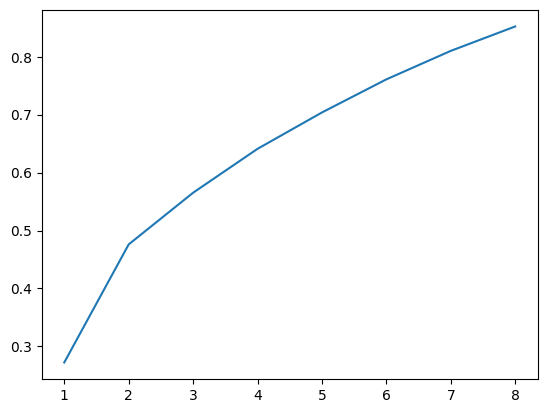

In [104]:
## Regla del codo
sns.lineplot(x=np.arange(1,9), y=np.cumsum(ve), palette='vidiris')

In [105]:
# variables latentes
l = pca.transform(feat_sc)
# latentes seleccionadas
l_sel = pd.DataFrame(l)
l_sel

,0,1,2,3,4,5,6,7
0,-1.696395,-1.122584,0.491562,0.719521,0.079830,0.118234,0.808993,-0.093970
1,-1.215681,2.435638,0.694658,-0.098843,0.803019,-0.917777,-0.322969,-0.045119
2,0.935853,-0.385202,-0.025953,1.293844,-1.987285,-0.682139,-1.624721,0.073401
3,-1.614638,-0.724586,0.272358,1.086116,-0.427814,0.082982,0.687001,0.063548
4,0.223701,-0.783610,-1.184434,0.721353,0.801243,0.525879,0.788893,-0.089942
...,...,...,...,...,...,...,...,...
8631,-2.221637,-1.328411,1.643826,-1.421354,-0.175573,3.518499,-1.313848,-0.870622
8632,-0.362326,-2.032249,-0.875053,-2.800940,-0.313566,2.808854,-1.549426,-0.210773
8633,-0.930026,-1.841236,-0.350037,-2.351591,-0.219492,3.090269,-1.421757,-0.630976
8634,-2.356010,-0.718730,1.048522,-1.776467,-0.552690,3.333452,-0.996810,-0.263088


## Aprendizaje no supervisado

<Axes: >

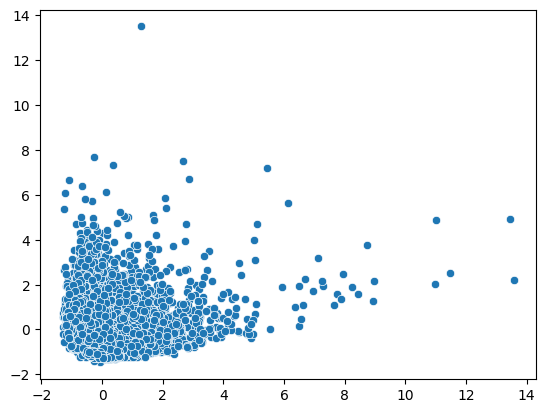

In [106]:
# Escalado de variables
x_s = StandardScaler().fit_transform(l_sel)
# Grafico de las variables sin clusteres
sns.scatterplot(x= x_s[:,0], y=x_s[:,1])

In [107]:
# modelo
gmm = GaussianMixture(n_components=5, covariance_type='full', n_init=5)
# ajustar
gmm.fit(x_s)
gmm.aic(x_s) ## indicador para comparar con otro modelo. Por si solo no se interpreta
gmm.bic(x_s) ## indicador para comparar con otro modelo. Por si solo no se interpreta
gmm.score(x_s) ## indicador de verosimilitud
gmm.predict_proba(x_s)[0] # Fila cero, probabilidad de pertenecia a cada uno de los 5 cluster

array([0.9979, 0.0021, 0.    , 0.    , 0.    ])

In [109]:
# grilla de hiperparametros
paramg = {
    'n_components':[3,4,5,6,7,8],
    'covariance_type':['full', 'tied', 'spherical', 'diag']
}

# Funcion para optimizar hiperparametros
gs = GridSearchCV(gmm, param_grid=paramg)
# ajustar modelo
gs.fit(x_s)

GridSearchCV(estimator=GaussianMixture(n_components=5, n_init=5),
             param_grid={'covariance_type': ['full', 'tied', 'spherical',
                                             'diag'],
                         'n_components': [3, 4, 5, 6, 7, 8]})

In [110]:
# Resultados
df_resultados = pd.DataFrame(gs.cv_results_)
df_resultados[['params', 'mean_test_score']].sort_values('mean_test_score', ascending = False)

,params,mean_test_score
5,"{'covariance_type': 'full', 'n_components': 8}",-4.018853
4,"{'covariance_type': 'full', 'n_components': 7}",-4.255713
3,"{'covariance_type': 'full', 'n_components': 6}",-4.594719
2,"{'covariance_type': 'full', 'n_components': 5}",-5.034131
1,"{'covariance_type': 'full', 'n_components': 4}",-6.170876
0,"{'covariance_type': 'full', 'n_components': 3}",-7.344027
23,"{'covariance_type': 'diag', 'n_components': 8}",-8.269674
22,"{'covariance_type': 'diag', 'n_components': 7}",-8.418307
17,"{'covariance_type': 'spherical', 'n_components...",-8.569090
21,"{'covariance_type': 'diag', 'n_components': 6}",-8.640784


<Axes: >

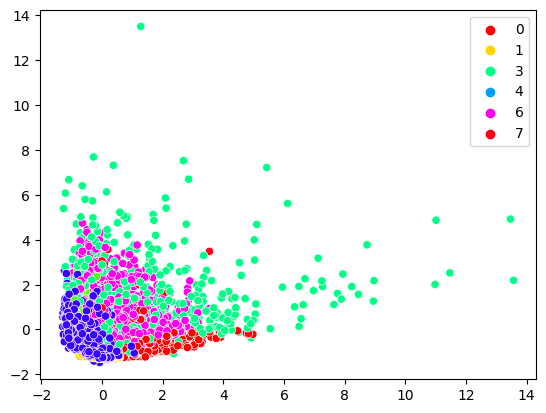

In [111]:
# ganadador
gmm_gan=gs.best_estimator_
# guardar los cluster en una variable
cluster = gmm_gan.fit_predict(x_s)
# graficar hue=categorias o clusteres
sns.scatterplot(x=x_s[:,0], y=x_s[:,1], hue=cluster, palette = 'hsv')